
##<b>Lecture07 컴퓨터 비젼 CIFAR10</b>

### 목표
 - ResNet 구조를 직접 구현 및 학습시켜 본다.
 - LeNet-5과 비교해본다.

### 참조
- Kaiming He et al., "Deep Residual Learning for Image Recognition," arxiv preprint arXiv:1512:03385 (2015).
- 오렐리앙 제롱. 핸즈온 머신러닝 3판. 박해선 역. 서울:한빛미디어(주), 2023.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Layer, Conv2D, GlobalAvgPool2D, Flatten, Dense, BatchNormalization, MaxPool2D, AveragePooling2D
from keras import Model
from keras import Sequential

## CIFAR-10
- 컬러 이미지 데이터
- 이미지(32, 32, 3): 60,000개 + 레이블: 60,000개

In [2]:
# CIFAR-10 불러오기
from keras.datasets import cifar10
'''
[데이터 분할]
    훈련 데이터 및 레이블(X_train, y_train) : 46,000개
    검증 데이터 및 레이블(X_valid, y_valid) : 4,000개
    테스트 데이터 및 레이블(X_test, y_test): 10,000개
'''
(X_full, y_full), (X_test, y_test) = cifar10.load_data()
X_train, y_train = X_full[:-4000], y_full[:-4000]
X_valid, y_valid = X_full[-4000:], y_full[-4000:]


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [3]:
label_name = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

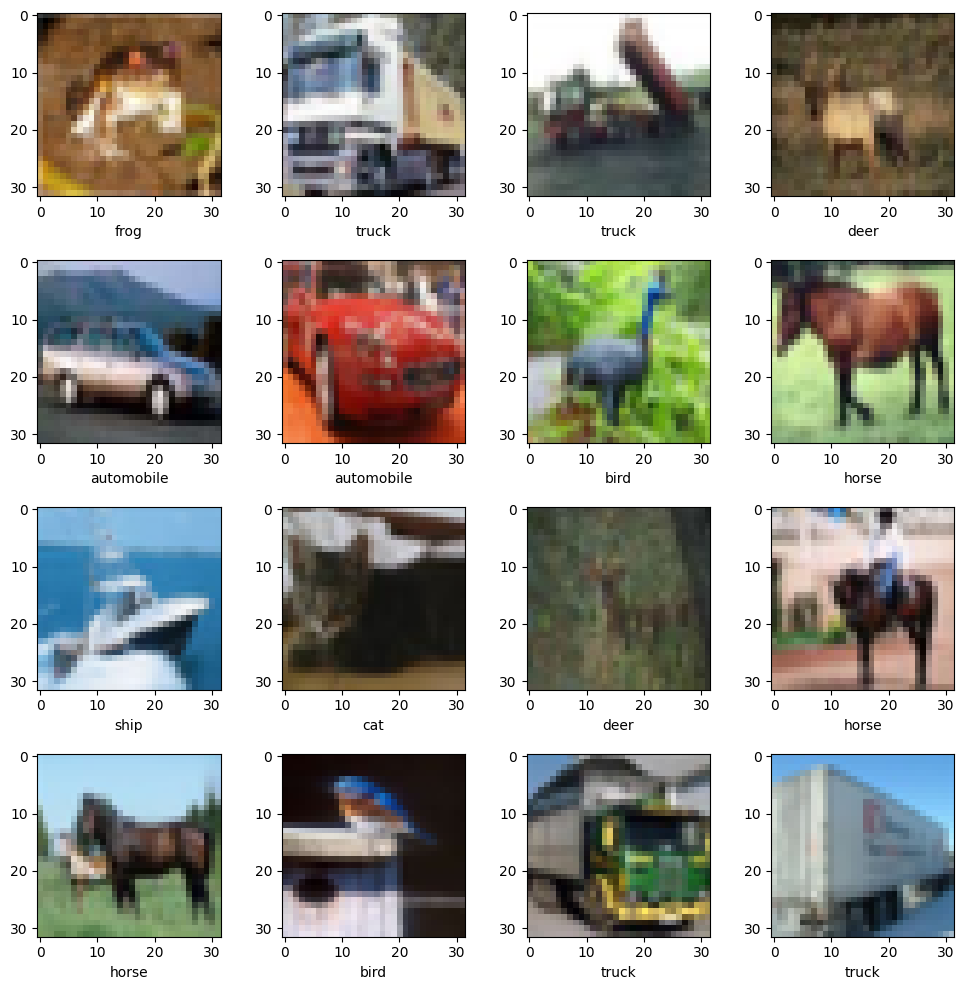

In [4]:
# 훈련 데이터 처음 16개 시각화

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.tight_layout()
    plt.imshow(X_train[i])
    plt.xlabel(label_name[y_train[i][0]])
plt.show()

In [5]:
## 이미지 데이터 전처리
# 이미지 값은 0~255이니 0~1 사이의 값으로 정규화를 진행한다.
X_train, X_valid, X_test = X_train/255.0, X_valid/255.0, X_test/255.0

In [6]:
## 라벨 데이터 전처리
# 라벨 데이터는 0~9사이의 값을 가진다. 이를 0과 1로 구성된 희소 벡터로 변환한다.
y_train = keras.utils.to_categorical(y_train)
y_valid = keras.utils.to_categorical(y_valid)
y_test = keras.utils.to_categorical(y_test)

##ResNet 구조
1. 입력: 이미지 텐서를 입력받는다.
    - (배치 크기, 224, 224, 3)
2. 합성곱 층(Convolution Layer)
    - filters: 64
    - kernel_size: (3, 3)
    - strides: (2, 2)
    - padding: same
3. 잔차 유닛(Residual Unit)
    - filters: 64, 128, 256, 512
    - kernel_size: (3, 3)
    - stride
        - 이전과 같은 filter 수 이면, (1, 1)
        - 그렇지 않다면, (2, 2)
    - padding: same
    - 유닛 수: 3, 4, 6, 3
4. 전역 평균 풀링
5. Flatten
6. 밀집 층


## 잔차 유닛 구조
1. main 층
    - 합성곱
    - 배치 정규화
    - 활성화 함수
    - 합성곱
    - 배치 정규화
2. skip 층
    - 이전 filter 수와 같으면, 입력 값을 가진다.
    - 이전 filter 수와 다르면, skip 층과 main 층의 텐서 크기를 맞추기위해 다음 층을 거친다.
        - 합성곱
        - 배치 정규화
3. 출력
    - main 층 + skip 층


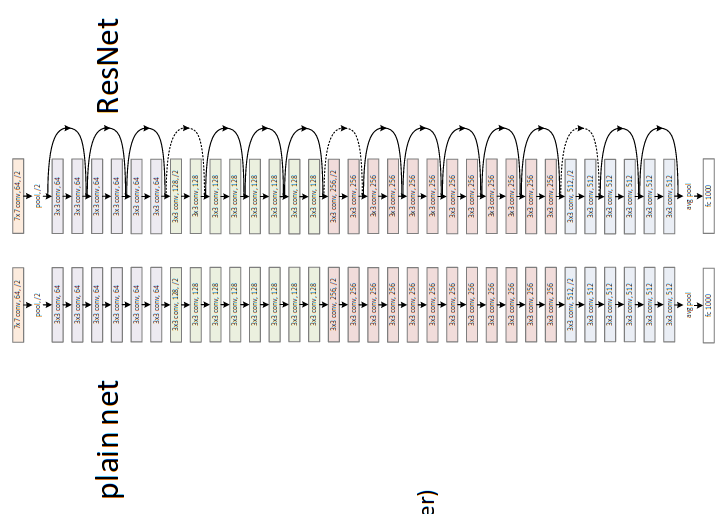

In [7]:
# 잔차 유닛 층을 구성한다.
class ResidualUnit(Layer):
    def __init__(self, filters, kernel_size , strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            Conv2D(filters, kernel_size=kernel_size, strides=strides, padding="same", use_bias=False),
            BatchNormalization(),
            self.activation,
            Conv2D(filters, kernel_size=kernel_size, strides=1, padding="same", use_bias=False),
            BatchNormalization()
        ]

        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                Conv2D(filters, kernel_size=1, strides=strides, padding="same", use_bias=False),
                BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip = inputs
        for layer in self.skip_layers:
            skip = layer(skip)
        return self.activation(Z + skip)


In [8]:
## 시퀀셜 클래스를 이용해 ResNet 구현
ResNet34 =  Sequential([
    Conv2D(64, kernel_size=7, strides=2, padding="same", use_bias=False),
    BatchNormalization(),
    keras.layers.Activation("relu"),
    MaxPool2D(pool_size=3, strides=2, padding="same")
])

init_filters = 64
filters = [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3
for f in filters:
    if f == init_filters:
        ResNet34.add(ResidualUnit(f, 3))
    else:
        ResNet34.add(ResidualUnit(f, 3, strides=2))

    init_filters = f

ResNet34.add(
    keras.models.Sequential([
        GlobalAvgPool2D(),
        Flatten(),
        Dense(10, activation="softmax")
    ])
)

In [9]:
# 모델 요약
ResNet34.build(input_shape=(None, 32, 32, 3))
ResNet34.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit (ResidualUnit)    │ (None, 8, 8, 64)       │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_1 (ResidualUnit)  │ (None, 8, 8, 64)       │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_2 (ResidualUnit)  │ (None, 8, 8, 64)       │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_3 (ResidualUnit)  │ (None, 4, 4, 128)      │       230,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_4 (ResidualUnit)  │ (None, 4, 4, 128)      │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_5 (ResidualUnit)  │ (None, 4, 4, 128)      │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_6 (ResidualUnit)  │ (None, 4, 4, 128)      │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_7 (ResidualUnit)  │ (None, 2, 2, 256)      │       920,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_8 (ResidualUnit)  │ (None, 2, 2, 256)      │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_9 (ResidualUnit)  │ (None, 2, 2, 256)      │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_10 (ResidualUnit) │ (None, 2, 2, 256)      │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_11 (ResidualUnit) │ (None, 2, 2, 256)      │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_12 (ResidualUnit) │ (None, 2, 2, 256)      │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_13 (ResidualUnit) │ (None, 1, 1, 512)      │     3,676,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_14 (ResidualUnit) │ (None, 1, 1, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_15 (ResidualUnit) │ (None, 1, 1, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,306,826 (81.28 MB)

 Trainable params: 21,289,802 (81.21 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [10]:
# 콜백함수 정의
tensorboard_resnet = keras.callbacks.TensorBoard(log_dir='./TF_logs/CIFAR10/ResNet34')
early_stopping_resnet = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [11]:
# 모델 컴파일
ResNet34.compile(loss='crossentropy',
                 optimizer='sgd',
                 metrics=['accuracy'])

In [13]:
# 모델 학습
history_resnet = ResNet34.fit(X_train, y_train,
                              epochs=30,
                              validation_data=(X_valid, y_valid),
                              callbacks=[tensorboard_resnet, early_stopping_resnet])

Epoch 1/30
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 52s 24ms/step - accuracy: 0.3544 - loss: 2.0523 - val_accuracy: 0.2262 - val_loss: 5.0944
Epoch 2/30


KeyboardInterrupt: 

In [ ]:
# 모델 평가
ResNet34.evaluate(X_test, y_test)

In [ ]:
# 시각화
num = int(input("숫자를 입력하세요(0~10,000): "))

img = X_test[num]
label = y_test[num]

plt.figure(figsize=(5,5))
plt.xlabel(label_name[label])
plt.imshow(img)
plt.show()

pred = ResNet34.predict(img.reshape(1, 32, 32, 3))
print("모델이 예측한 값: ", pred.argmax())

## 실험
ResNet과 LeNet5을 비교하여 깊이에 따른 정확성을 알아본다.

In [ ]:
# LeNet5 구현
LeNet5 = Sequential([
    Conv2D(filters = 6, kernel_size = (5, 5), strides = (1, 1), padding = 'valid', activation='relu'),  # C1
    AveragePooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'),                          # S2
    Conv2D(filters = 16, kernel_size = (5, 5), strides = (1, 1), padding = 'valid', activation='relu'), # C3
    AveragePooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'),                          # S4
    Flatten(),                                                                                          # C5
    Dense(units = 84, activation='relu'),                                                               # F6
    Dense(units = 10, activation='softmax')                                                             # F7
])

In [ ]:
# LeNet-5 모델 요약
LeNet5.build(input_shape=(None, 32, 32, 3))
LeNet5.summary()

In [ ]:
# 콜백함수 정의
tensorboard_cb_lenet = keras.callbacks.TensorBoard(log_dir='./TF_logs/CIFAR10/LeNet5')
early_stopping_cb_lenet = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
# 모델 컴파일
LeNet5.compile(loss='crossentropy',
               optimizer='sgd',
               metrics=['accuracy'])

In [ ]:
# 모델 학습
history = LeNet5.fit(X_train, y_train,
                     epochs=30,
                     validation_data=(X_valid, y_valid),
                     callbacks=[tensorboard_cb_lenet, early_stopping_cb_lenet])

In [ ]:
# 모델 평가
LeNet5.evaluate(X_test, y_test)

In [ ]:
# 시각화
num = int(input("숫자를 입력하세요(0~10,000): "))

img = X_test[num]
label = y_test[num]

plt.figure(figsize=(5,5))
plt.xlabel(label_name[label])
plt.imshow(img)
plt.show()

pred = LeNet5.predict(img.reshape(1, 32, 32, 3))
print("모델이 예측한 값: ", pred.argmax())

In [ ]:
## tensorboard 활성화
%pip install -q -U tensorboard-plugin-profile
%load_ext tensorboard
%tensorboard --logdir=./TF_logs/CIFAR10

## 결과
- ResNet이 LeNet에 비해 더욱 높은 정확도로 학습이 마무리 되었다. 모델이 깊을 수록 더욱 풍부하고 고차원적인 특징을 인식할 수 있기 때문으로 보인다.
- 특이한점은 ResNet이 LeNet에 비해 더 많은 파라미터를 가지고 있음에도 불구하고 더욱 적은 에포크만에 학습이 완료되었다. 즉, 잔차유닛의 스킵 연결이 모델의 결정표면을 매끄럽게 해주어, 그레디언트 소실문제를 완화해줄 뿐 아니라 학습이 더욱 용이 하게 해줌을 알 수 있다.